In [2]:
pip install keras_tuner

In [3]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from keras_tuner import Hyperband
from tensorflow.keras import layers, models, callbacks

# --- FinBERT sentiment imports ---
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch.nn.functional as F

In [4]:
# 0) Reproducibility
tf.random.set_seed(42)
np.random.seed(42)

# 1) Config
SYMBOL         = 'NVDA'
START_DATE     = '2022-01-01'
END_DATE       = '2024-12-31'
SEQ_LEN        = 30
TEST_SIZE      = 0.2
MAX_EPOCHS     = 50
BATCH_SIZE     = 32
FUTURE_DAYS    = 30   # ← predict next 30 days

In [5]:
# 2) Load stock data from CSV
df = pd.read_csv('stock_data.csv', parse_dates=['Date'], index_col='Date')
df = df.loc[(df.index >= START_DATE) & (df.index <= END_DATE)]
# Explicitly remove the 'Date' column if it exists, as the index is already 'Date'
if 'Date' in df.columns:
    df = df.drop(columns=['Date'])

In [6]:
df.head()

,Close,High,Low,Open,Volume
Date,,,,,
2022-01-03,30.068224,30.657190,29.732812,29.762760,391547000
2022-01-04,29.238680,30.414615,28.299329,30.223950,527154000
2022-01-05,27.555634,29.364459,27.484759,28.898276,498064000
2022-01-06,28.128626,28.388171,27.017577,27.591568,454186000
2022-01-07,27.199257,28.372199,27.009589,28.091691,409939000


In [7]:
# 3) Feature engineering
df['MA10'] = df['Close'].rolling(10).mean()
df['EMA20'] = df['Close'].ewm(span=20).mean()
delta = df['Close'].diff()
up = delta.clip(lower=0)
down = -delta.clip(upper=0)
avg_gain = up.rolling(14).mean()
avg_loss = down.rolling(14).mean()
df['RSI'] = 100 - 100 / (1 + avg_gain/avg_loss)
df['Return'] = df['Close'].pct_change()
df.fillna(method='bfill', inplace=True)

/tmp/ipython-input-7-3103199377.py:11: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='bfill', inplace=True)


In [8]:
df.head()

,Close,High,Low,Open,Volume,MA10,EMA20,RSI,Return
Date,,,,,,,,,
2022-01-03,30.068224,30.657190,29.732812,29.762760,391547000,27.868383,30.068224,16.70446,-0.027589
2022-01-04,29.238680,30.414615,28.299329,30.223950,527154000,27.868383,29.632713,16.70446,-0.027589
2022-01-05,27.555634,29.364459,27.484759,28.898276,498064000,27.868383,28.870022,16.70446,-0.057562
2022-01-06,28.128626,28.388171,27.017577,27.591568,454186000,27.868383,28.655992,16.70446,0.020794
2022-01-07,27.199257,28.372199,27.009589,28.091691,409939000,27.868383,28.303621,16.70446,-0.033040


In [9]:
# ======================= #
# 3.5) SENTIMENT FEATURE  #
# ======================= #
# Load and preprocess news data
news_df = pd.read_csv('nvidia_news.csv', parse_dates=['Date'])

In [10]:
news_df.head()

,Title,Link,Source,Date
0,Nvidia Stock To $60?,https://www.forbes.com/sites/greatspeculations...,Forbes,2022-01-03
1,"Markets News, Mar. 1, 2024: Nasdaq Climbs to A...",https://www.investopedia.com/dow-jones-today-0...,Investopedia,2022-01-04
2,"NVIDIA Launches Salvo Of Gaming GPUs, New Omni...",https://www.forbes.com/sites/davealtavilla/202...,Forbes,2022-01-05
3,Early NVIDIA GeForce RTX 3080 12 GB benchmarks...,https://www.notebookcheck.net/Early-NVIDIA-GeF...,Notebookcheck,2022-01-06
4,AMD Radeon RX 6300M and RX 6500M to feature Na...,https://www.notebookcheck.net/AMD-Radeon-RX-63...,Notebookcheck,2022-01-07


In [11]:
news_df['Date'] = pd.to_datetime(news_df['Date']).dt.date  # keep only date

# Load FinBERT model and tokenizer
tokenizer = AutoTokenizer.from_pretrained('ProsusAI/finbert')
model = AutoModelForSequenceClassification.from_pretrained('ProsusAI/finbert')

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/252 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/758 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/438M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

In [12]:
def get_finbert_sentiment(texts, batch_size=32):
    model.eval()
    all_scores = []
    with torch.no_grad():
        for i in range(0, len(texts), batch_size):
            batch_texts = texts[i:i+batch_size]
            encoded_input = tokenizer(batch_texts, padding=True, truncation=True, return_tensors='pt')
            outputs = model(**encoded_input)
            probs = F.softmax(outputs.logits, dim=-1).cpu().numpy()
            all_scores.extend(probs)
    return np.array(all_scores)

# Get sentiment scores for all news titles
news_texts = news_df['Title'].astype(str).tolist()
sentiment_scores = get_finbert_sentiment(news_texts)

# Add sentiment columns to news_df
news_df['neg'] = sentiment_scores[:, 0]
news_df['neu'] = sentiment_scores[:, 1]
news_df['pos'] = sentiment_scores[:, 2]

In [13]:
news_df.head()

,Title,Link,Source,Date,neg,neu,pos
0,Nvidia Stock To $60?,https://www.forbes.com/sites/greatspeculations...,Forbes,2022-01-03,0.116059,0.028572,0.855369
1,"Markets News, Mar. 1, 2024: Nasdaq Climbs to A...",https://www.investopedia.com/dow-jones-today-0...,Investopedia,2022-01-04,0.916383,0.030425,0.053191
2,"NVIDIA Launches Salvo Of Gaming GPUs, New Omni...",https://www.forbes.com/sites/davealtavilla/202...,Forbes,2022-01-05,0.128847,0.010969,0.860184
3,Early NVIDIA GeForce RTX 3080 12 GB benchmarks...,https://www.notebookcheck.net/Early-NVIDIA-GeF...,Notebookcheck,2022-01-06,0.332687,0.015826,0.651487
4,AMD Radeon RX 6300M and RX 6500M to feature Na...,https://www.notebookcheck.net/AMD-Radeon-RX-63...,Notebookcheck,2022-01-07,0.819219,0.011189,0.169592


In [14]:
# Compute daily average sentiment
daily_sentiment = news_df.groupby('Date')[['neg', 'neu', 'pos']].mean()
# Weighted sentiment: +1*pos, 0*neu, -1*neg
daily_sentiment['sentiment'] = (
    daily_sentiment['pos'] * 1 +
    daily_sentiment['neu'] * 0 +
    daily_sentiment['neg'] * -1
)

In [15]:
daily_sentiment.head()

,neg,neu,pos,sentiment
Date,,,,
2022-01-03,0.116059,0.028572,0.855369,0.739310
2022-01-04,0.916383,0.030425,0.053191,-0.863192
2022-01-05,0.128847,0.010969,0.860184,0.731336
2022-01-06,0.332687,0.015826,0.651487,0.318799
2022-01-07,0.819219,0.011189,0.169592,-0.649626


In [16]:
# ——— CORRECTED merge block ———
# ensure daily_sentiment.index is datetime64 so it lines up exactly with df.index
daily_sentiment.index = pd.to_datetime(daily_sentiment.index)

# merge on the DatetimeIndex directly
df = df.merge(
    daily_sentiment[['sentiment']],
    left_index=True,
    right_index=True,
    how='left'
)

# fill missing sentiment days with 0
df['sentiment'].fillna(0, inplace=True)


/tmp/ipython-input-16-341636670.py:14: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['sentiment'].fillna(0, inplace=True)


In [17]:
df.head()

,Close,High,Low,Open,Volume,MA10,EMA20,RSI,Return,sentiment
Date,,,,,,,,,,
2022-01-03,30.068224,30.657190,29.732812,29.762760,391547000,27.868383,30.068224,16.70446,-0.027589,0.739310
2022-01-04,29.238680,30.414615,28.299329,30.223950,527154000,27.868383,29.632713,16.70446,-0.027589,-0.863192
2022-01-05,27.555634,29.364459,27.484759,28.898276,498064000,27.868383,28.870022,16.70446,-0.057562,0.731336
2022-01-06,28.128626,28.388171,27.017577,27.591568,454186000,27.868383,28.655992,16.70446,0.020794,0.318799
2022-01-07,27.199257,28.372199,27.009589,28.091691,409939000,27.868383,28.303621,16.70446,-0.033040,-0.649626


In [18]:
# 4) Prepare features & scaling
features = ['Open','High','Low','Close','Volume','MA10','EMA20','RSI','Return','sentiment']
scaler = MinMaxScaler()
scaled = scaler.fit_transform(df[features])

In [19]:
# 5) Build sequences
X, y = [], []
for i in range(len(scaled) - SEQ_LEN):
    X.append(scaled[i:i+SEQ_LEN])
    y.append(scaled[i+SEQ_LEN, features.index('Close')])
X = np.array(X)
y = np.array(y)

In [20]:
# 6) Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=TEST_SIZE, shuffle=False)

In [21]:
# 7) Attention Layer definition
class AttentionLayer(layers.Layer):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
    def build(self, input_shape):
        self.W = self.add_weight(shape=(input_shape[-1], 1),
                                 initializer='glorot_uniform',
                                 trainable=True)
        super().build(input_shape)
    def call(self, inputs):
        e = tf.matmul(tf.tanh(inputs), self.W)    # (batch, time, 1)
        alpha = tf.nn.softmax(e, axis=1)           # normalize over time
        context = tf.reduce_sum(inputs * alpha, axis=1)
        return context

In [22]:
# 8) Hypermodel builder for Keras Tuner
def build_model(hp):
    inp = layers.Input(shape=(SEQ_LEN, len(features)))
    x = layers.Bidirectional(
        layers.LSTM(
            units=hp.Int('lstm1_units', 32, 256, step=32),
            return_sequences=True,
            dropout=hp.Float('dropout1', 0.0, 0.5, step=0.1)
        )
    )(inp)
    x = AttentionLayer()(x)
    x = layers.Dense(
        units=hp.Int('dense_units', 16, 128, step=16),
        activation='relu'
    )(x)
    x = layers.Dropout(hp.Float('dropout2', 0.0, 0.5, step=0.1))(x)
    out = layers.Dense(1)(x)

    model = models.Model(inputs=inp, outputs=out)
    model.compile(
        optimizer=tf.keras.optimizers.Adam(
            hp.Float('lr', 1e-4, 1e-2, sampling='log')
        ),
        loss='mse',
        metrics=['mae', 'mape']
    )
    return model

In [23]:
# 9) Hyperparameter search
tuner = Hyperband(
    build_model,
    objective='val_loss',
    max_epochs=MAX_EPOCHS,
    factor=3,
    directory='tuner_dir',
    project_name='nvda_lstm_attention'
)
stop_early = callbacks.EarlyStopping(monitor='val_loss', patience=10)
tuner.search(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=MAX_EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=[stop_early],
    verbose=1
)

Trial 90 Complete [00h 01m 08s]
val_loss: 0.0056916493922472

Best val_loss So Far: 0.0013343022437766194
Total elapsed time: 00h 35m 50s


In [24]:

# 10) Retrieve the best model
best_model = tuner.get_best_models(num_models=1)[0]

In [25]:

# 11) Final training (fine-tune)
best_model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=20,
    batch_size=BATCH_SIZE,
    callbacks=[
        callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5),
        callbacks.ModelCheckpoint('best_attention_lstm.keras', save_best_only=True)
    ],
    verbose=1
)


Epoch 1/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 5s 61ms/step - loss: 0.0055 - mae: 0.0552 - mape: 588.7894 - val_loss: 0.0114 - val_mae: 0.0992 - val_mape: 11.4669 - learning_rate: 0.0053
Epoch 2/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 6.3614e-04 - mae: 0.0184 - mape: 2202.0657 - val_loss: 0.0052 - val_mae: 0.0616 - val_mape: 7.6444 - learning_rate: 0.0053
Epoch 3/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 3.9227e-04 - mae: 0.0139 - mape: 1633.1083 - val_loss: 0.0014 - val_mae: 0.0288 - val_mape: 3.6001 - learning_rate: 0.0053
Epoch 4/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 1.6286e-04 - mae: 0.0087 - mape: 230.9849 - val_loss: 0.0017 - val_mae: 0.0310 - val_mape: 3.8839 - learning_rate: 0.0053
Epoch 5/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 1.4421e-04 - mae: 0.0084 - mape: 803.4140 - val_loss: 0.0024 - val_mae: 0.0391 - val_mape: 4.8493 - learning_rate: 0.0053
Epoch 6/20
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 1.7174e-04 - mae: 0.0092 - mape: 1526

In [26]:
# 12) Evaluation
y_pred = best_model.predict(X_test)
dummy = np.zeros((len(y_pred), len(features)))
dummy[:, features.index('Close')] = y_pred.flatten()
pred_prices = scaler.inverse_transform(dummy)[:, features.index('Close')]
dummy[:, features.index('Close')] = y_test
true_prices = scaler.inverse_transform(dummy)[:, features.index('Close')]

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
rmse = np.sqrt(mean_squared_error(true_prices, pred_prices))
mae  = mean_absolute_error(true_prices, pred_prices)
mape = np.mean(np.abs((true_prices - pred_prices) / true_prices)) * 100
r2   = r2_score(true_prices, pred_prices)

print(f"Enhanced LSTM+Attention Results:")
print(f"RMSE: ${rmse:.2f}")
print(f"MAE : ${mae:.2f}")
print(f"MAPE: {mape:.2f}%")
print(f"R²  : {r2:.4f}")

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step
Enhanced LSTM+Attention Results:
RMSE: $4.79
MAE : $3.61
MAPE: 2.96%
R²  : 0.8390


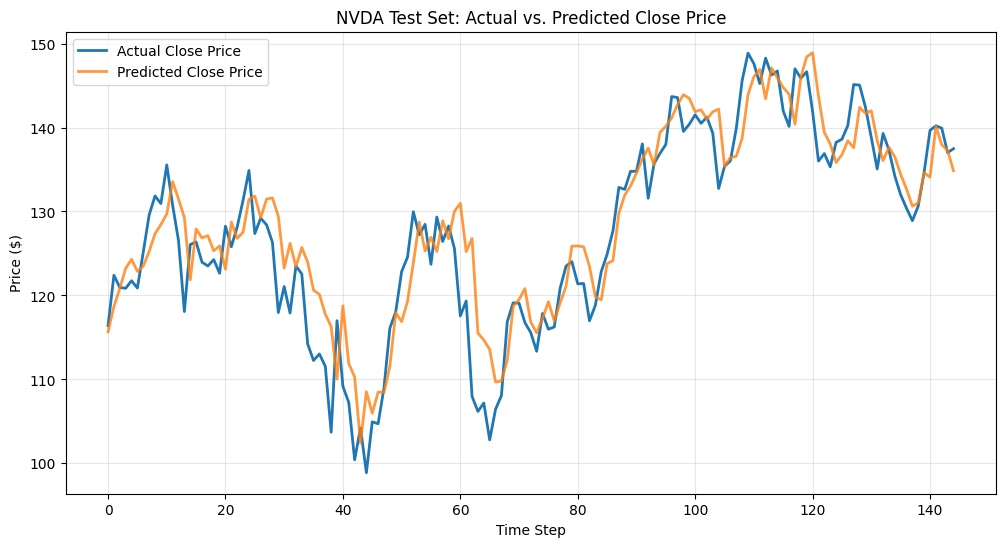

In [27]:

# 13) Plot test set actual vs. predicted
plt.figure(figsize=(12, 6))
plt.plot(true_prices, label='Actual Close Price', linewidth=2)
plt.plot(pred_prices, label='Predicted Close Price', linewidth=2, alpha=0.8)
plt.title(f'{SYMBOL} Test Set: Actual vs. Predicted Close Price')
plt.xlabel('Time Step')
plt.ylabel('Price ($)')
plt.legend()
plt.grid(alpha=0.3)
plt.show()


In [28]:
# 14) Predict next 30 days
last_seq = scaled[-SEQ_LEN:].reshape(1, SEQ_LEN, len(features))
future_preds = []
last_date = df.index[-1]

for _ in range(FUTURE_DAYS):
    p = best_model.predict(last_seq)[0, 0]
    tmp = np.zeros((1, len(features)))
    tmp[0, features.index('Close')] = p
    price = scaler.inverse_transform(tmp)[0, features.index('Close')]
    future_preds.append(price)
    new_scaled = np.zeros(len(features))
    new_scaled[features.index('Close')] = p
    last_seq = np.concatenate([last_seq[:, 1:, :], new_scaled.reshape(1, 1, -1)], axis=1)

future_dates = [last_date + timedelta(i+1) for i in range(FUTURE_DAYS)]
df_future = pd.DataFrame({
    'Date': future_dates,
    'Predicted_Close': future_preds
}).set_index('Date')

print("\nFuture 30-Day Predictions:")
print(df_future.round(2))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━

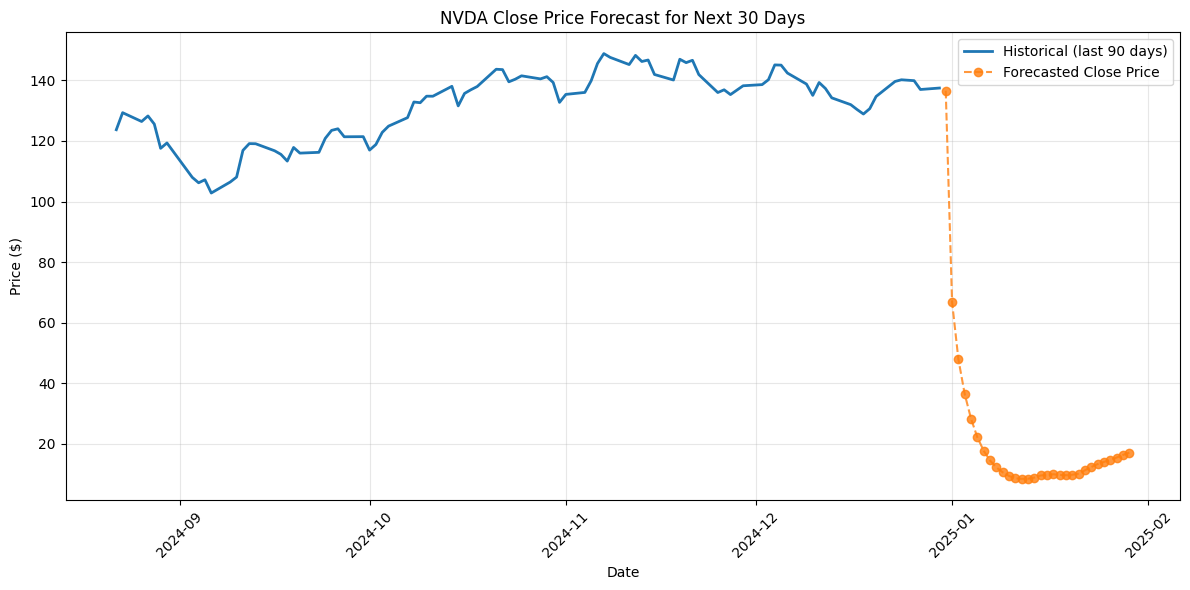

In [29]:
# 15) Plot future forecast
plt.figure(figsize=(12, 6))
plt.plot(df['Close'].iloc[-90:], label='Historical (last 90 days)', linewidth=2)
plt.plot(df_future.index, df_future['Predicted_Close'], '--o', label='Forecasted Close Price', alpha=0.8)
plt.title(f'{SYMBOL} Close Price Forecast for Next {FUTURE_DAYS} Days')
plt.xlabel('Date')
plt.ylabel('Price ($)')
plt.legend()
plt.grid(alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
